In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import re
import time
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
get_ipython().run_line_magic("matplotlib", "inline")

In [3]:
csv_file_path = '/content/drive/MyDrive/01/최종라벨링1.csv'

dataset = pd.read_csv(csv_file_path)

dataset

,content,label
0,이종석 한효주 나오는 드라마 이후로 드라마 안봤다. 2년전인가?? 좀 신선했었지. ...,1
1,씨바알..노무노무 술프노... 오늘 저녁은 꽂등심이다ㅠㅜ,1
2,짱깨 꺼라ㅡ패쓰,1
3,그들의 사생활 ~ 고인이된 설리를 위해서라도 모두 조용하길 지금 누굴 탓한다고 무슨...,0
4,아무리 법이 뭣같아도 무슨 자격으로 개인의 신상정보를 불특정 다수에게 공개하는지 도...,0
...,...,...
28735,저게 시대적언어면 한남충도 시대적언어 아니노 ㅋㅋ,1
28736,다른것보다 눈이 어떻게 저렇게 생기노.탄식.,1
28737,막노동을 해도 한국에살고말지 미쳤다고 남미를가냐?차라리 자살을하겠다.,1
28738,‘사형을 구형하였으나 여성인 점을 감안해 25년 선고’ ???내가 뭐 잘못본건가?개...,1


## label '0'= 비악플, '1'= 악플

## 1. EDA (전처리 전)

In [7]:
dataset_info = dataset.info()
dataset_head = dataset.head()
dataset_description = dataset.describe()

dataset_info, dataset_head, dataset_description

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28740 entries, 0 to 28739
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  28740 non-null  object
 1   label    28740 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 449.2+ KB


(None,
                                              content  label
 0  이종석 한효주 나오는 드라마 이후로 드라마 안봤다. 2년전인가?? 좀 신선했었지. ...      1
 1                    씨바알..노무노무 술프노... 오늘 저녁은 꽂등심이다ㅠㅜ      1
 2                                           짱깨 꺼라ㅡ패쓰      1
 3  그들의 사생활 ~ 고인이된 설리를 위해서라도 모두 조용하길 지금 누굴 탓한다고 무슨...      0
 4  아무리 법이 뭣같아도 무슨 자격으로 개인의 신상정보를 불특정 다수에게 공개하는지 도...      0,
               label
 count  28740.000000
 mean       0.668580
 std        0.470732
 min        0.000000
 25%        0.000000
 50%        1.000000
 75%        1.000000
 max        1.000000)

### label 분포 확인

In [8]:
label_cnt = dataset['label'].value_counts()
label_cnt

label
1    19215
0     9525
Name: count, dtype: int64

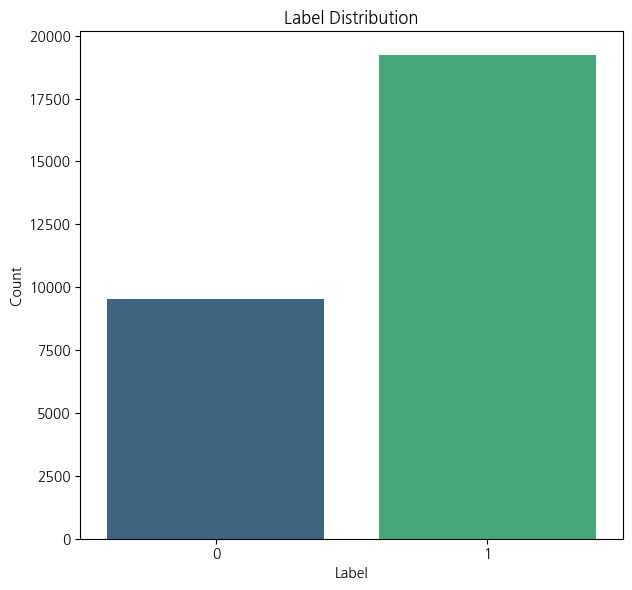

In [9]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=label_cnt.index, y=label_cnt.values, palette='viridis')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

### 가장 빈번한 단어

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
word_counts = vectorizer.fit_transform(dataset['content'])
word_counts_sum = word_counts.sum(axis=0)
words_freq = [(word, word_counts_sum[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:10]

words_freq

[('ㅋㅋ', 1169),
 ('진짜', 1144),
 ('그냥', 770),
 ('ㅋㅋㅋ', 698),
 ('존나', 613),
 ('너무', 520),
 ('근데', 445),
 ('씨발', 374),
 ('시발', 365),
 ('하는', 332)]

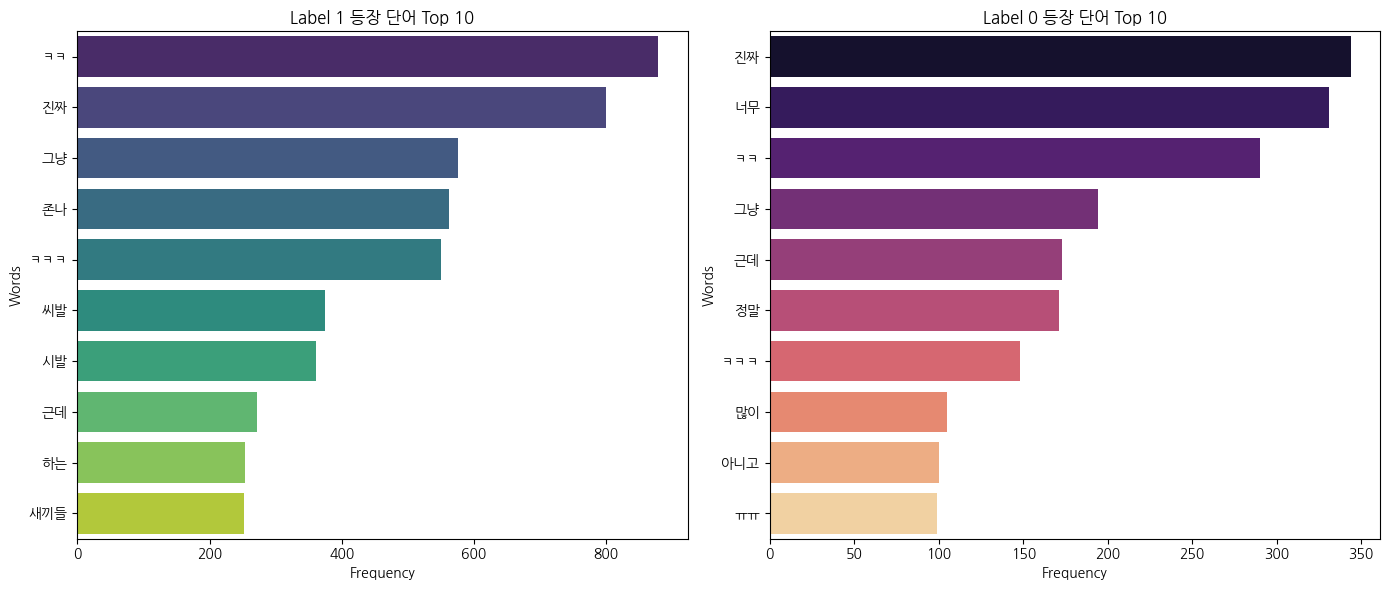

In [11]:
text_label_1 = dataset[dataset['label'] == 1]['content']
text_label_0 = dataset[dataset['label'] == 0]['content']

vectorizer_1 = CountVectorizer(stop_words='english')
vectorizer_0 = CountVectorizer(stop_words='english')

word_counts_1 = vectorizer_1.fit_transform(text_label_1)
word_counts_0 = vectorizer_0.fit_transform(text_label_0)

word_counts_sum_1 = word_counts_1.sum(axis=0)
word_counts_sum_0 = word_counts_0.sum(axis=0)

words_freq_1 = [(word, word_counts_sum_1[0, idx]) for word, idx in vectorizer_1.vocabulary_.items()]
words_freq_0 = [(word, word_counts_sum_0[0, idx]) for word, idx in vectorizer_0.vocabulary_.items()]

words_freq_1 = sorted(words_freq_1, key=lambda x: x[1], reverse=True)[:10]
words_freq_0 = sorted(words_freq_0, key=lambda x: x[1], reverse=True)[:10]

freq_df_1 = pd.DataFrame(words_freq_1, columns=['word', 'frequency'])
freq_df_0 = pd.DataFrame(words_freq_0, columns=['word', 'frequency'])

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(data=freq_df_1, x='frequency', y='word', palette='viridis')
plt.title('Label 1 등장 단어 Top 10')
plt.xlabel('Frequency')
plt.ylabel('Words')

plt.subplot(1, 2, 2)
sns.barplot(data=freq_df_0, x='frequency', y='word', palette='magma')
plt.title('Label 0 등장 단어 Top 10')
plt.xlabel('Frequency')
plt.ylabel('Words')

plt.tight_layout()
plt.show()


In [12]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_grams(corpus, n=None, ngram_range=(2, 2), top=10):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top]

top_2_label_1 = get_top_n_grams(text_label_1, ngram_range=(2, 2))
top_2_label_0 = get_top_n_grams(text_label_0, ngram_range=(2, 2))

top_2_label_1, top_2_label_0

([('좆족 좆족', 19),
  ('위장홍어다 ㅁㅈㅎ줘라이새끼', 17),
  ('ㅁㅈㅎ줘라이새끼 위장홍어다', 17),
  ('아니 시발', 13),
  ('개슬람 새끼들', 13),
  ('진짜 존나', 11),
  ('하지 마라', 10),
  ('근데 진짜', 10),
  ('시발 ㅋㅋ', 10),
  ('말도 안되는', 10)],
 [('요시 요시', 29),
  ('명복을 빕니다', 20),
  ('고인의 명복을', 14),
  ('삼가 고인의', 12),
  ('근데 진짜', 8),
  ('이제 그만', 7),
  ('아니 근데', 7),
  ('너무 좋아요', 7),
  ('행복하게 사세요', 6),
  ('진짜 너무', 6)])

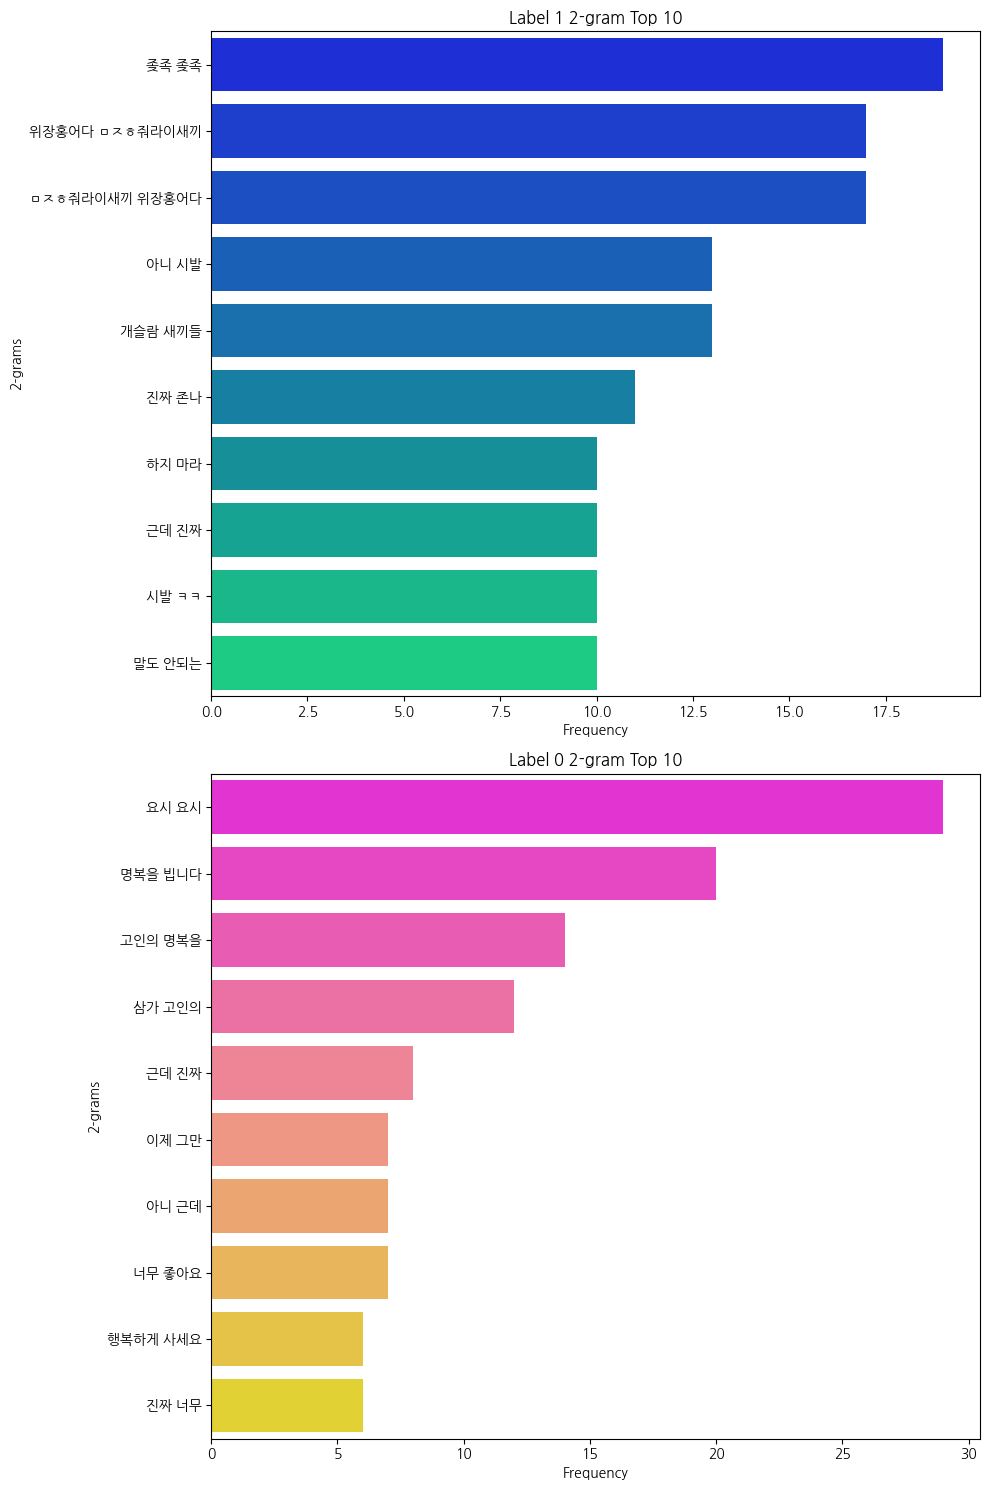

In [13]:
top_2_label_1_df = pd.DataFrame(top_2_label_1, columns=['ngram', 'frequency'])


top_2_label_0_df = pd.DataFrame(top_2_label_0, columns=['ngram', 'frequency'])


plt.figure(figsize=(10, 15))
plt.subplot(2, 1, 1)
sns.barplot(data=top_2_label_1_df, x='frequency', y='ngram', palette='winter')
plt.title('Label 1 2-gram Top 10')
plt.xlabel('Frequency')
plt.ylabel('2-grams')

plt.subplot(2, 1, 2)
sns.barplot(data=top_2_label_0_df, x='frequency', y='ngram', palette='spring')
plt.title('Label 0 2-gram Top 10')
plt.xlabel('Frequency')
plt.ylabel('2-grams')

plt.tight_layout()
plt.show()

In [14]:
top_3_label_1 = get_top_n_grams(text_label_1, ngram_range=(3, 3))
top_3_label_0 = get_top_n_grams(text_label_0, ngram_range=(3, 3))

top_3_label_1, top_3_label_0

([('위장홍어다 ㅁㅈㅎ줘라이새끼 위장홍어다', 17),
  ('좆족 좆족 좆족', 17),
  ('ㅁㅈㅎ줘라이새끼 위장홍어다 ㅁㅈㅎ줘라이새끼', 16),
  ('퉤퉤퉤 퉤퉤퉤 퉤퉤퉤', 7),
  ('구라임이글 구라임이글 구라임이글', 7),
  ('한남죽어 한남죽어 한남죽어', 5),
  ('짤게에서 맨날 예수', 4),
  ('맨날 예수 찬양하는', 4),
  ('교회 교회 교회', 4),
  ('개소리하면서 도망가지 말고', 3)],
 [('요시 요시 요시', 28),
  ('고인의 명복을 빕니다', 13),
  ('삼가 고인의 명복을', 10),
  ('갓명박 갓명박 갓명박', 5),
  ('비비탄 총으로 저거', 4),
  ('가족 모두가 만수무강', 3),
  ('좋은 기사 감사합니다', 3),
  ('누가 비비탄 총으로', 3),
  ('총으로 저거 터뜨려라', 3),
  ('고멘나사이 고멘나사이 고멘나사이', 3)])

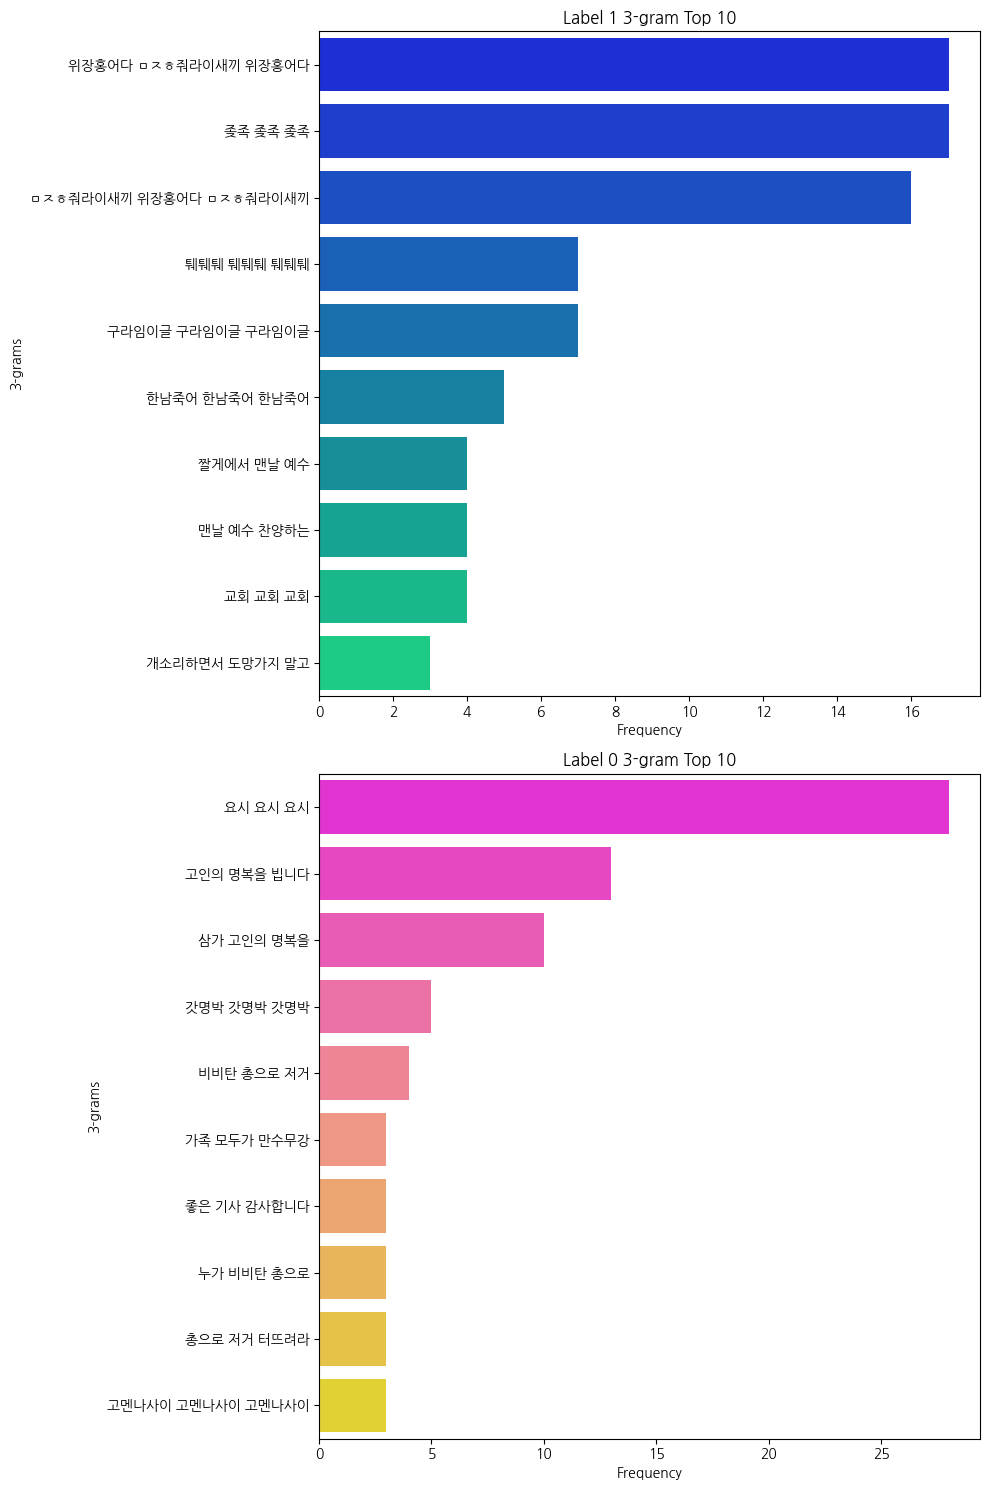

In [15]:
top_3_label_1_df = pd.DataFrame(top_3_label_1, columns=['ngram', 'frequency'])
top_3_label_0_df = pd.DataFrame(top_3_label_0, columns=['ngram', 'frequency'])

plt.figure(figsize=(10, 15))
plt.subplot(2, 1, 1)
sns.barplot(data=top_3_label_1_df, x='frequency', y='ngram', palette='winter')
plt.title('Label 1 3-gram Top 10')
plt.xlabel('Frequency')
plt.ylabel('3-grams')

plt.subplot(2, 1, 2)
sns.barplot(data=top_3_label_0_df, x='frequency', y='ngram', palette='spring')
plt.title('Label 0 3-gram Top 10')
plt.xlabel('Frequency')
plt.ylabel('3-grams')

plt.tight_layout()
plt.show()

In [16]:
top_4_label_1 = get_top_n_grams(text_label_1, ngram_range=(4, 4))
top_4_label_0 = get_top_n_grams(text_label_0, ngram_range=(4, 4))

top_4_label_1, top_4_label_0

([('위장홍어다 ㅁㅈㅎ줘라이새끼 위장홍어다 ㅁㅈㅎ줘라이새끼', 16),
  ('ㅁㅈㅎ줘라이새끼 위장홍어다 ㅁㅈㅎ줘라이새끼 위장홍어다', 16),
  ('좆족 좆족 좆족 좆족', 15),
  ('퉤퉤퉤 퉤퉤퉤 퉤퉤퉤 퉤퉤퉤', 6),
  ('구라임이글 구라임이글 구라임이글 구라임이글', 6),
  ('짤게에서 맨날 예수 찬양하는', 4),
  ('한남죽어 한남죽어 한남죽어 한남죽어', 4),
  ('개소리하면서 도망가지 말고 근거', 3),
  ('도망가지 말고 근거 가져와', 3),
  ('말고 근거 가져와 씨발', 3)],
 [('요시 요시 요시 요시', 27),
  ('삼가 고인의 명복을 빕니다', 9),
  ('갓명박 갓명박 갓명박 갓명박', 4),
  ('누가 비비탄 총으로 저거', 3),
  ('비비탄 총으로 저거 터뜨려라', 3),
  ('통신비 지원할게 아니라 차라리', 2),
  ('지원할게 아니라 차라리 독감예방주사', 2),
  ('아니라 차라리 독감예방주사 한대씩', 2),
  ('차라리 독감예방주사 한대씩 놔주는게', 2),
  ('독감예방주사 한대씩 놔주는게 좋을거', 2)])

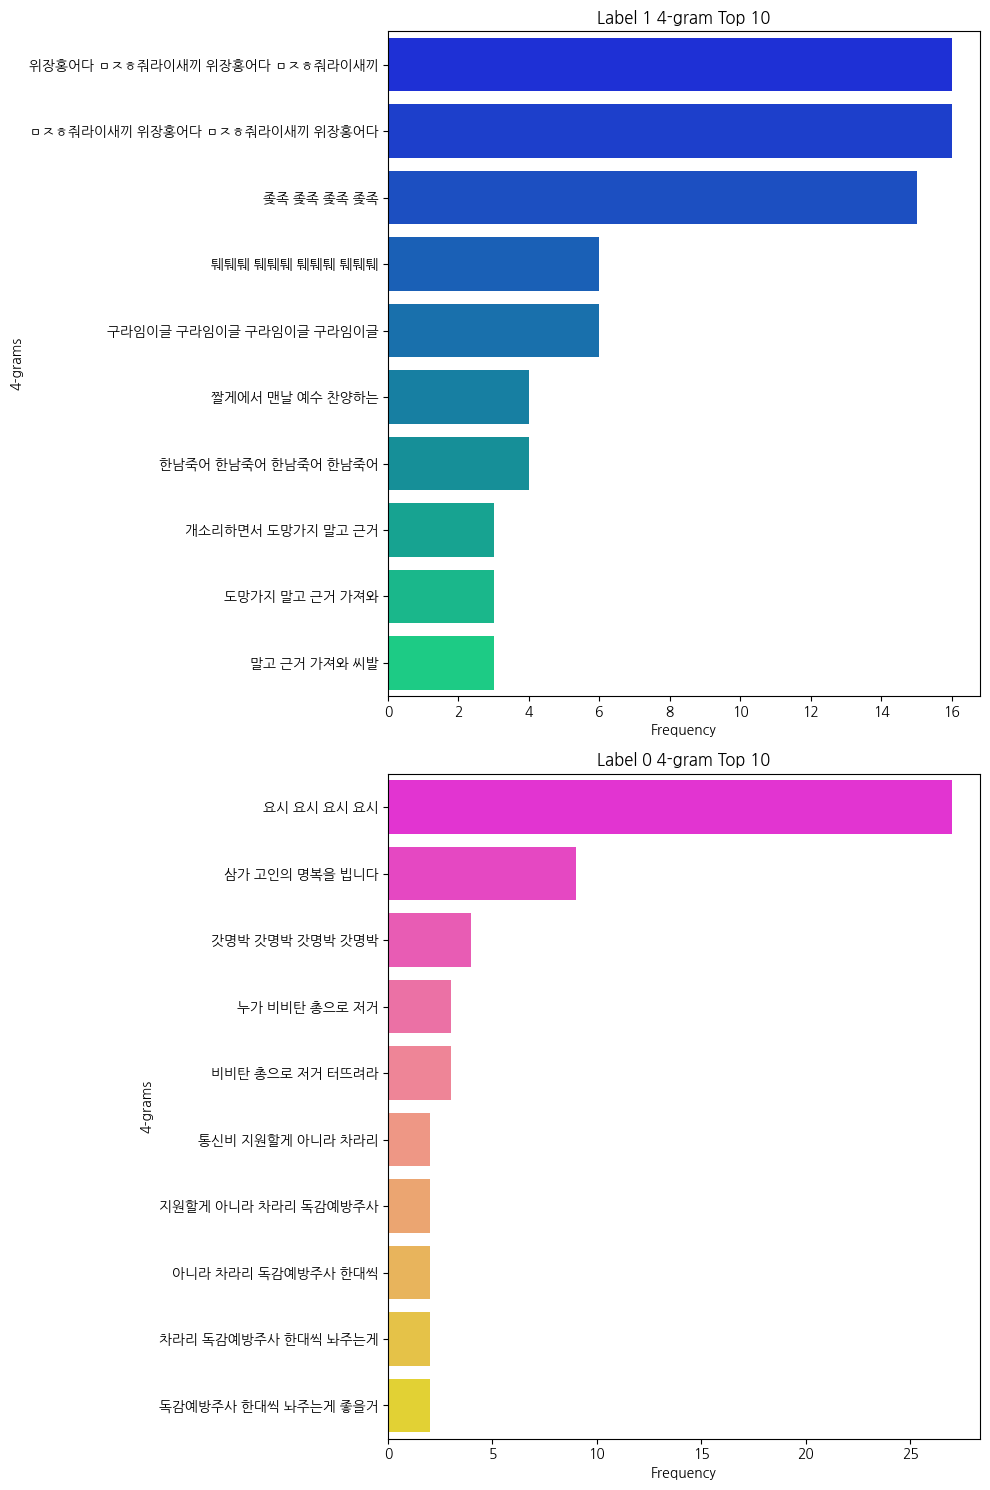

In [17]:
top_4_label_1_df = pd.DataFrame(top_4_label_1, columns=['ngram', 'frequency'])
top_4_label_0_df = pd.DataFrame(top_4_label_0, columns=['ngram', 'frequency'])

plt.figure(figsize=(10, 15))
plt.subplot(2, 1, 1)
sns.barplot(data=top_4_label_1_df, x='frequency', y='ngram', palette='winter')
plt.title('Label 1 4-gram Top 10')
plt.xlabel('Frequency')
plt.ylabel('4-grams')

plt.subplot(2, 1, 2)
sns.barplot(data=top_4_label_0_df, x='frequency', y='ngram', palette='spring')
plt.title('Label 0 4-gram Top 10')
plt.xlabel('Frequency')
plt.ylabel('4-grams')

plt.tight_layout()
plt.show()


### Label 텍스트 길이 분포

In [18]:
dataset['text_length'] = dataset['content'].apply(len)
text_length_description = dataset['text_length'].describe()

In [19]:
text_len_label_1 = dataset[dataset['label'] == 1]['text_length']
len_1 = text_len_label_1.describe()

print(f"Label 1 텍스트 길이 분포 통계: {len_1}")

Label 1 텍스트 길이 분포 통계: count    19215.000000
mean        43.425709
std         34.119691
min          2.000000
25%         20.000000
50%         34.000000
75%         58.000000
max        841.000000
Name: text_length, dtype: float64


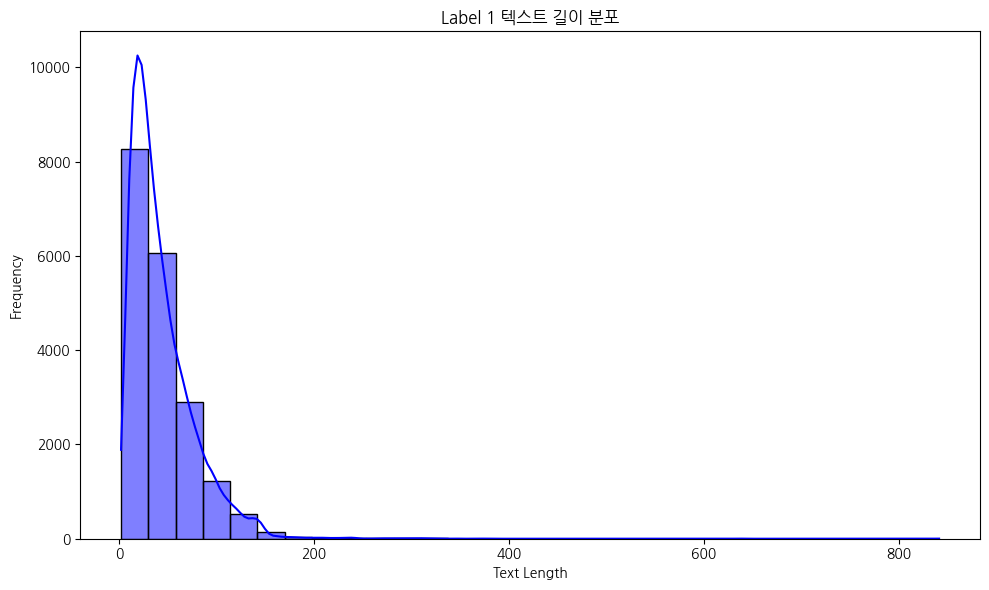

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(text_len_label_1, bins=30, kde=True, color='blue')
plt.title('Label 1 텍스트 길이 분포')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [21]:
text_len_label_0 = dataset[dataset['label'] == 1]['text_length']
len_0 = text_len_label_0.describe()

print(f"Label 0 텍스트 길이 분포 통계: {len_0}")

Label 0 텍스트 길이 분포 통계: count    19215.000000
mean        43.425709
std         34.119691
min          2.000000
25%         20.000000
50%         34.000000
75%         58.000000
max        841.000000
Name: text_length, dtype: float64


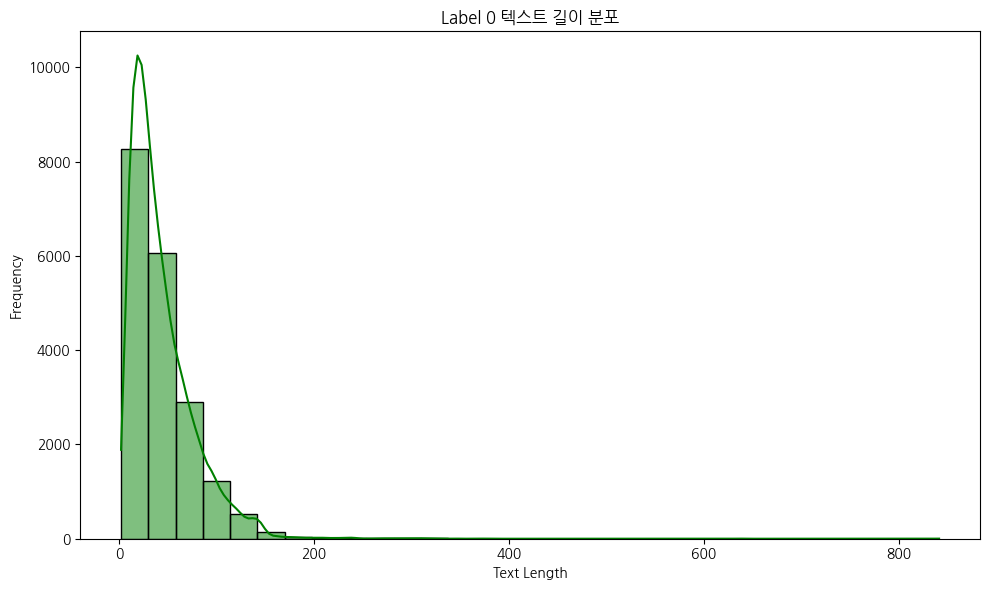

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(text_len_label_0, bins=30, kde=True, color='green')
plt.title('Label 0 텍스트 길이 분포')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [23]:
!pip install wordcloud matplotlib
!apt-get update -qq
!apt-get install -qq fonts-nanum

In [24]:
from wordcloud import WordCloud
import matplotlib.font_manager as fm

plt.rc('font', family='NanumGothic')

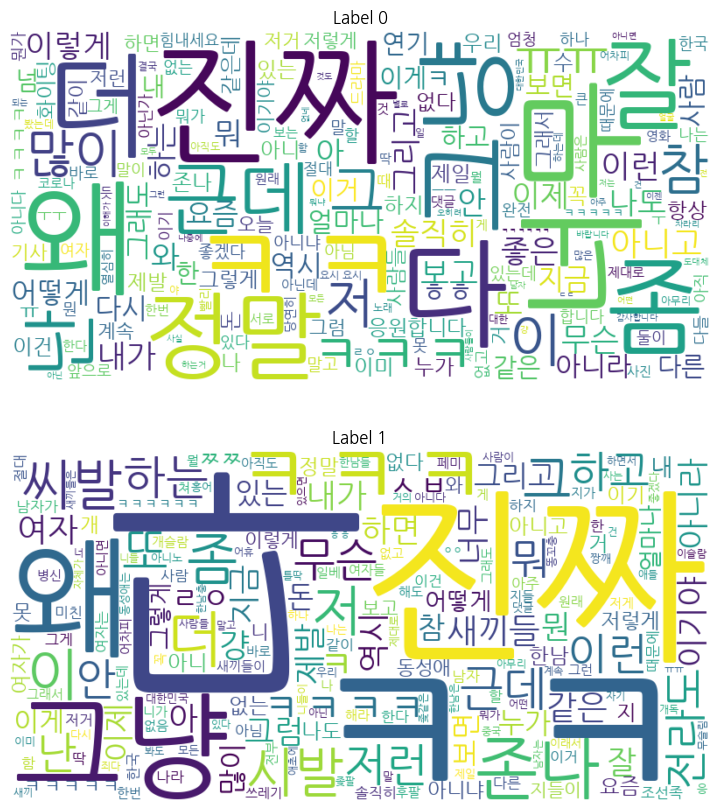

In [25]:
label_0_data = dataset[dataset['label'] == 0]
label_1_data = dataset[dataset['label'] == 1]

text_0 = " ".join(review for review in label_0_data.content)
text_1 = " ".join(review for review in label_1_data.content)

wordcloud_0 = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
                        width=800, height=400, background_color='white').generate(text_0)
wordcloud_1 = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
                        width=800, height=400, background_color='white').generate(text_1)

plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.title('Label 0')
plt.axis('off')

plt.subplot(2, 1, 2)
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.title('Label 1')
plt.axis('off')

plt.show()

## 2. 자연어 데이터 전처리

In [4]:
pip install konlpy nltk

In [5]:
from konlpy.tag import Okt
from nltk.corpus import stopwords

In [6]:
korean_stopwords = ['은', '는', '이', '가', '를', '을', '들', '도', '에', '의', '와', '한', '하다','로', '으로', '에서']

# 불용어 포함
def clean_ns(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[\u200b-\u200d\ufeff]', '', text)

    okt = Okt()
    tokens = okt.morphs(text)

    return ' '.join(tokens)

# 불용어 제거
def clean_ws(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[\u200b-\u200d\ufeff]', '', text)

    okt = Okt()
    tokens = okt.morphs(text)
    tokens = [word for word in tokens if word not in korean_stopwords]

    return ' '.join(tokens)

dataset['clean_cns'] = dataset['content'].apply(clean_ns)
dataset['clean_cws'] = dataset['content'].apply(clean_ws)

cleaned_data_sample = dataset[['content', 'clean_cns', 'clean_cws']].head()
cleaned_data_sample

,content,clean_cns,clean_cws
0,이종석 한효주 나오는 드라마 이후로 드라마 안봤다. 2년전인가?? 좀 신선했었지. ...,이종석 한효주 나오는 드라마 이후 로 드라마 안 봤다 년 전인 가 좀 신선했었지 근...,이종석 한효주 나오는 드라마 이후 드라마 안 봤다 년 전인 좀 신선했었지 근데 이런...
1,씨바알..노무노무 술프노... 오늘 저녁은 꽂등심이다ㅠㅜ,씨 바알 노무 노무 술프노 오늘 저녁 은 꽂 등심 이다 ㅠㅜ,씨 바알 노무 노무 술프노 오늘 저녁 꽂 등심 이다 ㅠㅜ
2,짱깨 꺼라ㅡ패쓰,짱깨 꺼라 ㅡ 패쓰,짱깨 꺼라 ㅡ 패쓰
3,그들의 사생활 ~ 고인이된 설리를 위해서라도 모두 조용하길 지금 누굴 탓한다고 무슨...,그 들 의 사생활 고인 이 된 설리 를 위 해서라도 모두 조용하길 지금 누굴 탓 한...,그 사생활 고인 된 설리 위 해서라도 모두 조용하길 지금 누굴 탓 한다고 무슨 소 ...
4,아무리 법이 뭣같아도 무슨 자격으로 개인의 신상정보를 불특정 다수에게 공개하는지 도...,아무리 법 이 뭣같아 도 무슨 자격 으로 개인 의 신상 정보 를 불 특정 다수 에게...,아무리 법 뭣같아 무슨 자격 개인 신상 정보 불 특정 다수 에게 공개 하는지 도저히...


In [7]:
korean_stopwords = ['은', '는', '이', '가', '를', '을', '들', '도', '에', '의', '와', '한', '하다','로', '으로', '에서']

def clean_sc(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[\u200b-\u200d\ufeff]', '', text)
    text = re.sub(r'[ㅡㅠㅜㅋㅎ]', '', text)

    okt = Okt()
    tokens = okt.morphs(text)
    tokens = [word for word in tokens if word not in korean_stopwords]

    return ' '.join(tokens)

dataset['clean_csc'] = dataset['content'].apply(clean_sc)
dataset

,content,label,clean_cns,clean_cws,clean_csc
0,이종석 한효주 나오는 드라마 이후로 드라마 안봤다. 2년전인가?? 좀 신선했었지. ...,1,이종석 한효주 나오는 드라마 이후 로 드라마 안 봤다 년 전인 가 좀 신선했었지 근...,이종석 한효주 나오는 드라마 이후 드라마 안 봤다 년 전인 좀 신선했었지 근데 이런...,이종석 한효주 나오는 드라마 이후 드라마 안 봤다 년 전인 좀 신선했었지 근데 이런...
1,씨바알..노무노무 술프노... 오늘 저녁은 꽂등심이다ㅠㅜ,1,씨 바알 노무 노무 술프노 오늘 저녁 은 꽂 등심 이다 ㅠㅜ,씨 바알 노무 노무 술프노 오늘 저녁 꽂 등심 이다 ㅠㅜ,씨 바알 노무 노무 술프노 오늘 저녁 꽂 등심 이다
2,짱깨 꺼라ㅡ패쓰,1,짱깨 꺼라 ㅡ 패쓰,짱깨 꺼라 ㅡ 패쓰,짱깨 꺼라 패쓰
3,그들의 사생활 ~ 고인이된 설리를 위해서라도 모두 조용하길 지금 누굴 탓한다고 무슨...,0,그 들 의 사생활 고인 이 된 설리 를 위 해서라도 모두 조용하길 지금 누굴 탓 한...,그 사생활 고인 된 설리 위 해서라도 모두 조용하길 지금 누굴 탓 한다고 무슨 소 ...,그 사생활 고인 된 설리 위 해서라도 모두 조용하길 지금 누굴 탓 한다고 무슨 소 ...
4,아무리 법이 뭣같아도 무슨 자격으로 개인의 신상정보를 불특정 다수에게 공개하는지 도...,0,아무리 법 이 뭣같아 도 무슨 자격 으로 개인 의 신상 정보 를 불 특정 다수 에게...,아무리 법 뭣같아 무슨 자격 개인 신상 정보 불 특정 다수 에게 공개 하는지 도저히...,아무리 법 뭣같아 무슨 자격 개인 신상 정보 불 특정 다수 에게 공개 하는지 도저히...
...,...,...,...,...,...
28735,저게 시대적언어면 한남충도 시대적언어 아니노 ㅋㅋ,1,저 게 시대 적 언어 면 한 남충 도 시대 적 언어 아니노 ㅋㅋ,저 게 시대 적 언어 면 남충 시대 적 언어 아니노 ㅋㅋ,저 게 시대 적 언어 면 남충 시대 적 언어 아니노
28736,다른것보다 눈이 어떻게 저렇게 생기노.탄식.,1,다른 것 보다 눈 이 어떻게 저렇게 생기노 탄식,다른 것 보다 눈 어떻게 저렇게 생기노 탄식,다른 것 보다 눈 어떻게 저렇게 생기노 탄식
28737,막노동을 해도 한국에살고말지 미쳤다고 남미를가냐?차라리 자살을하겠다.,1,막노동 을 해도 한국 에 살고말지 미쳤다고 남미 를 가냐 차라리 자살 을 하겠다,막노동 해도 한국 살고말지 미쳤다고 남미 가냐 차라리 자살 하겠다,막노동 해도 한국 살고말지 미쳤다고 남미 가냐 차라리 자살 하겠다
28738,‘사형을 구형하였으나 여성인 점을 감안해 25년 선고’ ???내가 뭐 잘못본건가?개...,1,사형 을 구형 하였으나 여성 인 점 을 감안 해 년 선고 내 가 뭐 잘못 본 건가 ...,사형 구형 하였으나 여성 인 점 감안 해 년 선고 내 뭐 잘못 본 건가 개 시발 보...,사형 구형 하였으나 여성 인 점 감안 해 년 선고 내 뭐 잘못 본 건가 개 시발 보...


In [8]:
from konlpy.tag import Okt

okt = Okt()

dataset['tokens_ns'] = dataset['clean_cns'].apply(okt.morphs)
dataset['tokens_ws'] = dataset['clean_cws'].apply(okt.morphs)
dataset['tokens_sp'] = dataset['clean_csc'].apply(okt.morphs)

dataset. head(10)

,content,label,clean_cns,clean_cws,clean_csc,tokens_ns,tokens_ws,tokens_sp
0,이종석 한효주 나오는 드라마 이후로 드라마 안봤다. 2년전인가?? 좀 신선했었지. ...,1,이종석 한효주 나오는 드라마 이후 로 드라마 안 봤다 년 전인 가 좀 신선했었지 근...,이종석 한효주 나오는 드라마 이후 드라마 안 봤다 년 전인 좀 신선했었지 근데 이런...,이종석 한효주 나오는 드라마 이후 드라마 안 봤다 년 전인 좀 신선했었지 근데 이런...,"[이종석, 한효주, 나오는, 드라마, 이후, 로, 드라마, 안, 봤다, 년, 전인,...","[이종석, 한효주, 나오는, 드라마, 이후, 드라마, 안, 봤다, 년, 전인, 좀,...","[이종석, 한효주, 나오는, 드라마, 이후, 드라마, 안, 봤다, 년, 전인, 좀,..."
1,씨바알..노무노무 술프노... 오늘 저녁은 꽂등심이다ㅠㅜ,1,씨 바알 노무 노무 술프노 오늘 저녁 은 꽂 등심 이다 ㅠㅜ,씨 바알 노무 노무 술프노 오늘 저녁 꽂 등심 이다 ㅠㅜ,씨 바알 노무 노무 술프노 오늘 저녁 꽂 등심 이다,"[씨, 바알, 노무, 노무, 술프노, 오늘, 저녁, 은, 꽂, 등심, 이다, ㅠㅜ]","[씨, 바알, 노무, 노무, 술프노, 오늘, 저녁, 꽂, 등심, 이다, ㅠㅜ]","[씨, 바알, 노무, 노무, 술프노, 오늘, 저녁, 꽂, 등심, 이다]"
2,짱깨 꺼라ㅡ패쓰,1,짱깨 꺼라 ㅡ 패쓰,짱깨 꺼라 ㅡ 패쓰,짱깨 꺼라 패쓰,"[짱깨, 꺼라, ㅡ, 패쓰]","[짱깨, 꺼라, ㅡ, 패쓰]","[짱깨, 꺼라, 패쓰]"
3,그들의 사생활 ~ 고인이된 설리를 위해서라도 모두 조용하길 지금 누굴 탓한다고 무슨...,0,그 들 의 사생활 고인 이 된 설리 를 위 해서라도 모두 조용하길 지금 누굴 탓 한...,그 사생활 고인 된 설리 위 해서라도 모두 조용하길 지금 누굴 탓 한다고 무슨 소 ...,그 사생활 고인 된 설리 위 해서라도 모두 조용하길 지금 누굴 탓 한다고 무슨 소 ...,"[그, 들, 의, 사생활, 고인, 이, 된, 설리, 를, 위, 해서라도, 모두, 조...","[그, 사생활, 고인, 된, 설리, 위, 해서라도, 모두, 조용하길, 지금, 누굴,...","[그, 사생활, 고인, 된, 설리, 위, 해서라도, 모두, 조용하길, 지금, 누굴,..."
4,아무리 법이 뭣같아도 무슨 자격으로 개인의 신상정보를 불특정 다수에게 공개하는지 도...,0,아무리 법 이 뭣같아 도 무슨 자격 으로 개인 의 신상 정보 를 불 특정 다수 에게...,아무리 법 뭣같아 무슨 자격 개인 신상 정보 불 특정 다수 에게 공개 하는지 도저히...,아무리 법 뭣같아 무슨 자격 개인 신상 정보 불 특정 다수 에게 공개 하는지 도저히...,"[아무리, 법, 이, 뭣같, 아, 도, 무슨, 자격, 으로, 개인, 의, 신상, 정...","[아무리, 법, 뭣같, 아, 무슨, 자격, 개인, 신상, 정보, 불, 특정, 다수,...","[아무리, 법, 뭣같, 아, 무슨, 자격, 개인, 신상, 정보, 불, 특정, 다수,..."
5,다음도 들어와라하고...다른 의견내는 유튜버 목 자르고....추아줌마 꺼 여기저기서...,1,다음 도 들어와라 하고 다른 의견 내는 유튜버 목 자르 고추 아줌마 꺼 여기저기 서...,다음 들어와라 하고 다른 의견 내는 유튜버 목 자르 고추 아줌마 꺼 여기저기 서 진...,다음 들어와라 하고 다른 의견 내는 유튜버 목 자르 고추 아줌마 꺼 여기저기 서 진...,"[다음, 도, 들어와라, 하고, 다른, 의견, 내는, 유튜버, 목, 자르, 고추, ...","[다음, 들어와라, 하고, 다른, 의견, 내는, 유튜버, 목, 자르, 고추, 아줌마...","[다음, 들어와라, 하고, 다른, 의견, 내는, 유튜버, 목, 자르, 고추, 아줌마..."
6,여자들도 아무한테나 자기야라고하는사람있는데 그것도성희롱인것같은데요,0,여자 들 도 아무 한 테 나 자기야 라고 하는 사람 있는데 그것 도 성희롱 인 것 ...,여자 아무 테 나 자기야 라고 하는 사람 있는데 그것 성희롱 인 것 같은데요,여자 아무 테 나 자기야 라고 하는 사람 있는데 그것 성희롱 인 것 같은데요,"[여자, 들, 도, 아무, 한, 테, 나, 자기야, 라고, 하는, 사람, 있는데, ...","[여자, 아무, 테, 나, 자기야, 라고, 하는, 사람, 있는데, 그것, 성희롱, ...","[여자, 아무, 테, 나, 자기야, 라고, 하는, 사람, 있는데, 그것, 성희롱, ..."
7,나경아 젖깐사진이나 인스타에 좀올려라 물좀빼게,1,나경 아 젖 깐 사진 이나 인스타 에 좀 올려라 물좀 빼게,나경 아 젖 깐 사진 이나 인스타 좀 올려라 물좀 빼게,나경 아 젖 깐 사진 이나 인스타 좀 올려라 물좀 빼게,"[나경, 아, 젖, 깐, 사진, 이나, 인스타, 에, 좀, 올려라, 물좀, 빼게]","[나경, 아, 젖, 깐, 사진, 이나, 인스타, 좀, 올려라, 물좀, 빼게]","[나경, 아, 젖, 깐, 사진, 이나, 인스타, 좀, 올려라, 물좀, 빼게]"
8,어린시절 가정교육 못 받은 애들은 절대 그 본성을 숨길수없지,1,어린시절 가정교육 못 받은 애 들 은 절대 그 본성 을 숨길수 없지,어린시절 가정교육 못 받은 애 절대 그 본성 숨길수 없지,어린시절 가정교육 못 받은 애 절대 그 본성 숨길수 없지,"[어린시절, 가정교육, 못, 받은, 애, 들, 은, 절대, 그, 본성, 을, 숨길수...","[어린시절, 가정교육, 못, 받은, 애, 절대, 그, 본성, 숨길수, 없지]","[어린시절, 가정교육, 못, 받은, 애, 절대, 그, 본성, 숨길수, 없지]"
9,지연이 얼굴은 더 배우같네...,0,지연 이 얼굴 은 더 배우 같네,지연 얼굴 더 배우 같네,지연 얼굴 더 배우 같네,"[지연, 이, 얼굴, 은, 더, 배우, 같네]","[지연, 얼굴, 더, 배우, 같네]","[지연, 얼굴, 더, 배우, 같네]"


In [10]:
dataset.to_csv('/content/drive/MyDrive/01/cleandata.csv', encoding = 'utf-8-sig')

## 3. EDA (전처리 후)

In [31]:
dataset.describe(include='all')

,content,label,text_length,clean_cns,clean_cws,clean_csc,tokens_ns,tokens_ws,tokens_sp
count,28740,28740.000000,28740.000000,28740,28740,28740,28740,28740,28740
unique,28725,NaN,NaN,28707,28700,28661,28707,28700,28661
top,이건 뭐 변호사 변론비용도 아니고.. 좀 심하네.,NaN,NaN,삼가 고인 의 명복 을 빕니다,,미친,"[삼가, 고인, 의, 명복, 을, 빕니다]",[],[미친]
freq,2,NaN,NaN,4,5,8,4,5,8
mean,NaN,0.668580,40.092415,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,0.470732,32.383863,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,0.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,0.000000,17.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,1.000000,31.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,1.000000,53.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
dataset.columns

Index(['content', 'label', 'text_length', 'clean_cns', 'clean_cws',
       'clean_csc', 'tokens_ns', 'tokens_ws', 'tokens_sp'],
      dtype='object')

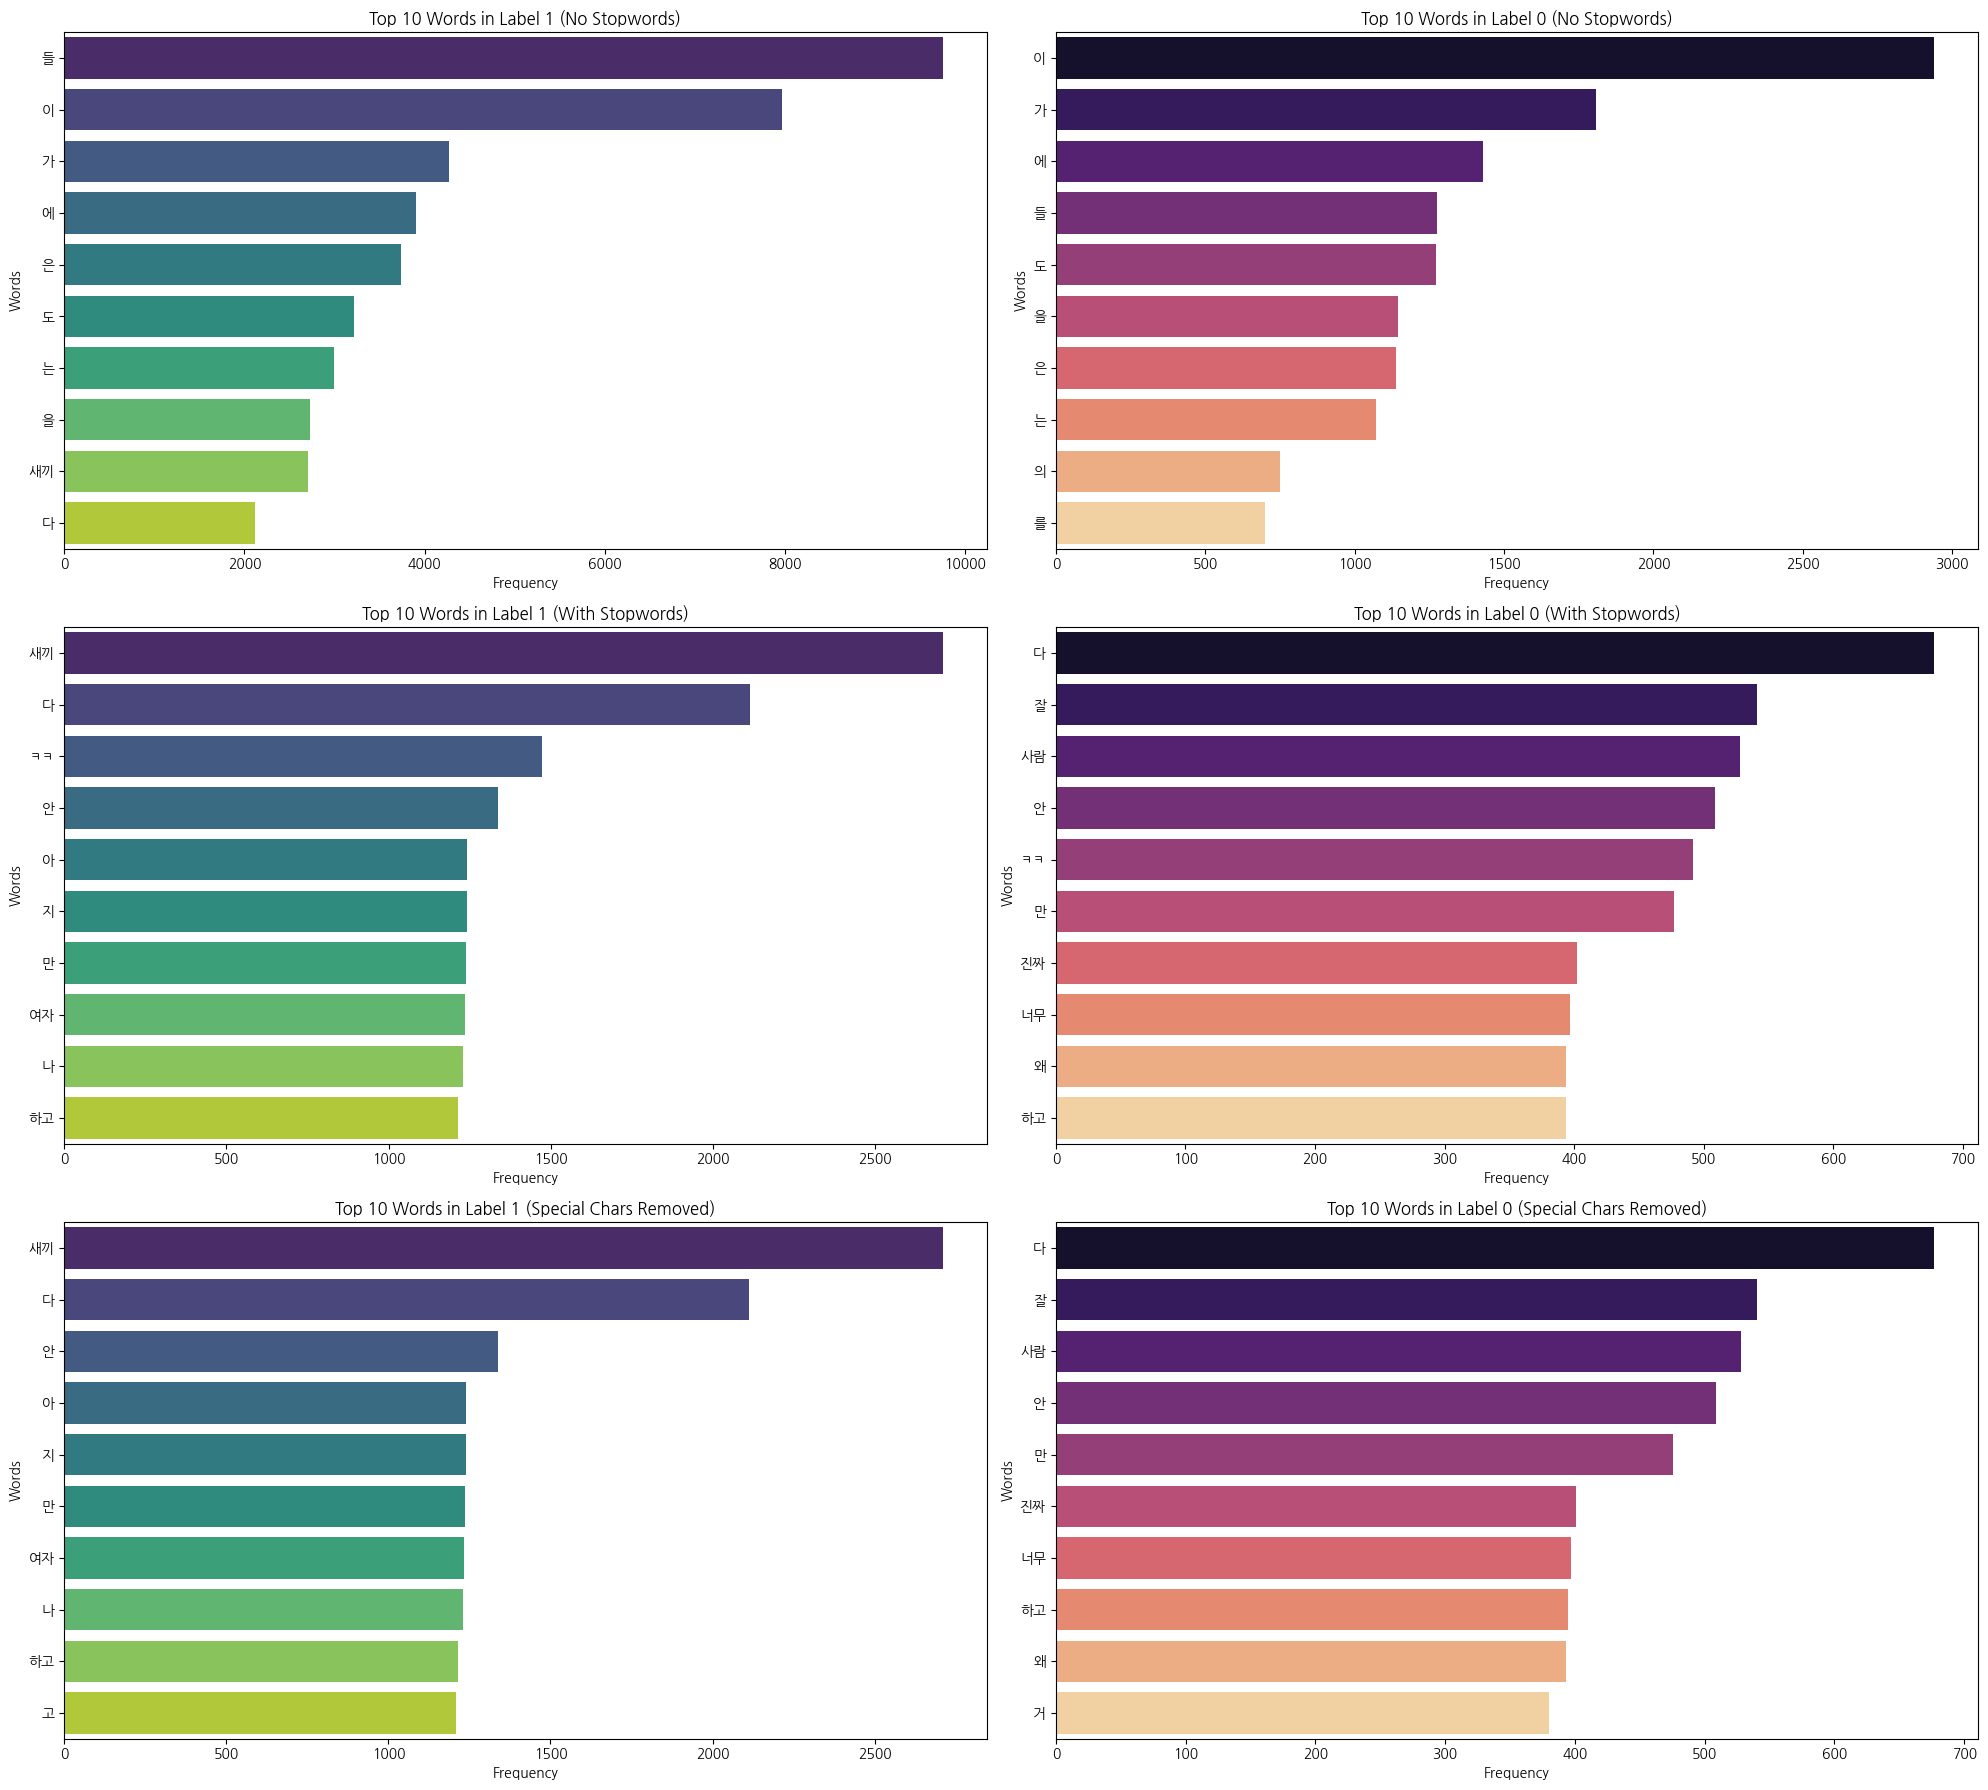

In [33]:
from collections import Counter

text_label_1_no_stopwords = dataset[dataset['label'] == 1]['clean_cns']
text_label_0_no_stopwords = dataset[dataset['label'] == 0]['clean_cns']

text_label_1_with_stopwords = dataset[dataset['label'] == 1]['clean_cws']
text_label_0_with_stopwords = dataset[dataset['label'] == 0]['clean_cws']

text_label_1_special_chars_removed = dataset[dataset['label'] == 1]['clean_csc']
text_label_0_special_chars_removed = dataset[dataset['label'] == 0]['clean_csc']

def get_top_n_words(texts, n=10):
    all_words = ' '.join(texts).split()
    counter = Counter(all_words)
    return counter.most_common(n)

top_words_label_1_no_stopwords = get_top_n_words(text_label_1_no_stopwords)
top_words_label_0_no_stopwords = get_top_n_words(text_label_0_no_stopwords)

top_words_label_1_with_stopwords = get_top_n_words(text_label_1_with_stopwords)
top_words_label_0_with_stopwords = get_top_n_words(text_label_0_with_stopwords)

top_words_label_1_special_chars_removed = get_top_n_words(text_label_1_special_chars_removed)
top_words_label_0_special_chars_removed = get_top_n_words(text_label_0_special_chars_removed)

df_label_1_no_stopwords = pd.DataFrame(top_words_label_1_no_stopwords, columns=['word', 'frequency'])
df_label_0_no_stopwords = pd.DataFrame(top_words_label_0_no_stopwords, columns=['word', 'frequency'])

df_label_1_with_stopwords = pd.DataFrame(top_words_label_1_with_stopwords, columns=['word', 'frequency'])
df_label_0_with_stopwords = pd.DataFrame(top_words_label_0_with_stopwords, columns=['word', 'frequency'])

df_label_1_special_chars_removed = pd.DataFrame(top_words_label_1_special_chars_removed, columns=['word', 'frequency'])
df_label_0_special_chars_removed = pd.DataFrame(top_words_label_0_special_chars_removed, columns=['word', 'frequency'])

plt.figure(figsize=(20, 18))

plt.subplot(3, 2, 1)
sns.barplot(data=df_label_1_no_stopwords, x='frequency', y='word', palette='viridis')
plt.title('Top 10 Words in Label 1 (No Stopwords)')
plt.xlabel('Frequency')
plt.ylabel('Words')

plt.subplot(3, 2, 2)
sns.barplot(data=df_label_0_no_stopwords, x='frequency', y='word', palette='magma')
plt.title('Top 10 Words in Label 0 (No Stopwords)')
plt.xlabel('Frequency')
plt.ylabel('Words')

plt.subplot(3, 2, 3)
sns.barplot(data=df_label_1_with_stopwords, x='frequency', y='word', palette='viridis')
plt.title('Top 10 Words in Label 1 (With Stopwords)')
plt.xlabel('Frequency')
plt.ylabel('Words')

plt.subplot(3, 2, 4)
sns.barplot(data=df_label_0_with_stopwords, x='frequency', y='word', palette='magma')
plt.title('Top 10 Words in Label 0 (With Stopwords)')
plt.xlabel('Frequency')
plt.ylabel('Words')

plt.subplot(3, 2, 5)
sns.barplot(data=df_label_1_special_chars_removed, x='frequency', y='word', palette='viridis')
plt.title('Top 10 Words in Label 1 (Special Chars Removed)')
plt.xlabel('Frequency')
plt.ylabel('Words')

plt.subplot(3, 2, 6)
sns.barplot(data=df_label_0_special_chars_removed, x='frequency', y='word', palette='magma')
plt.title('Top 10 Words in Label 0 (Special Chars Removed)')
plt.xlabel('Frequency')
plt.ylabel('Words')

plt.tight_layout()
plt.show()

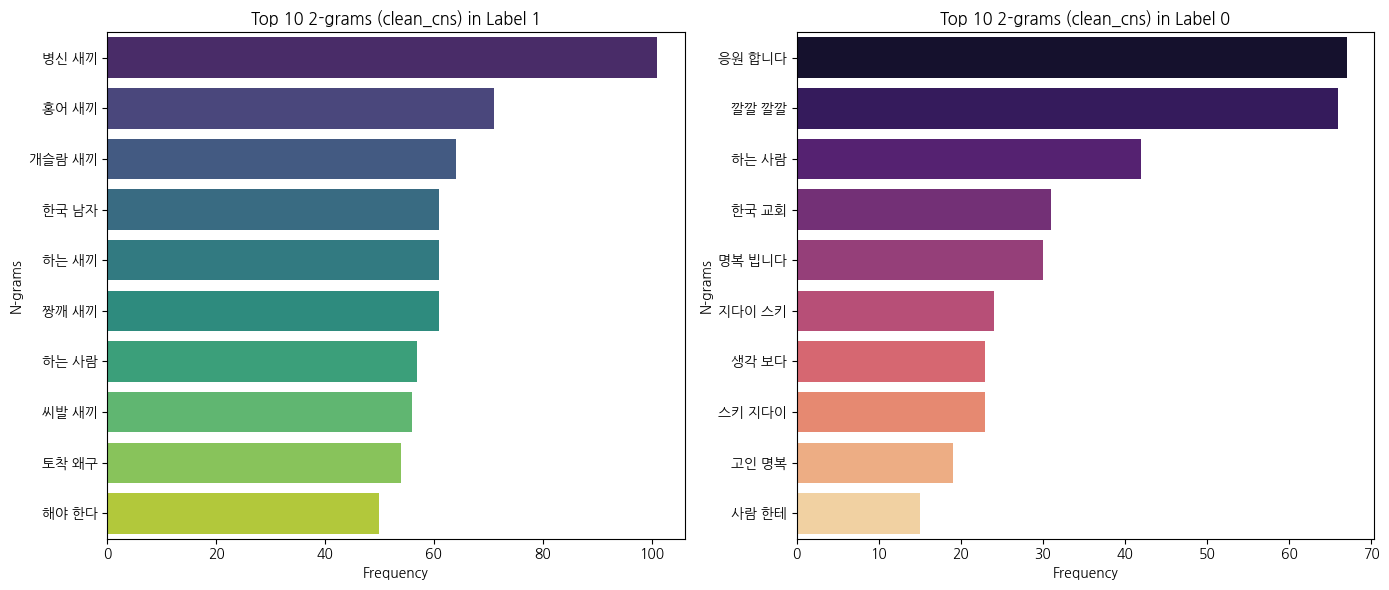

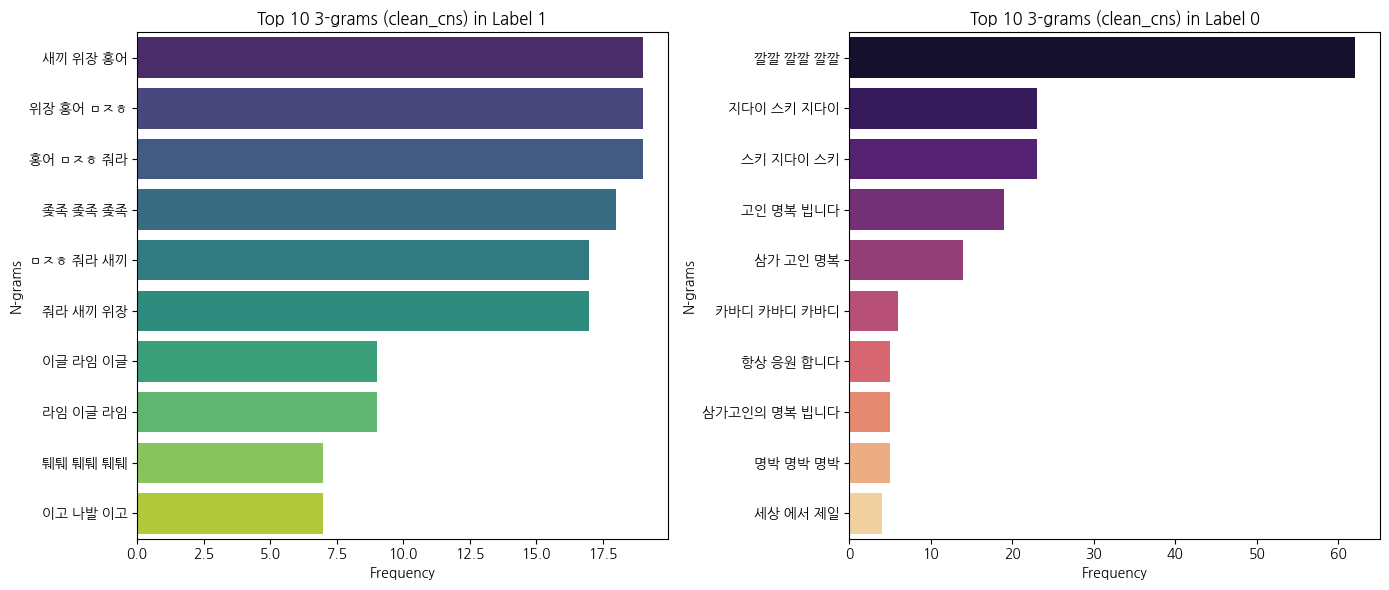

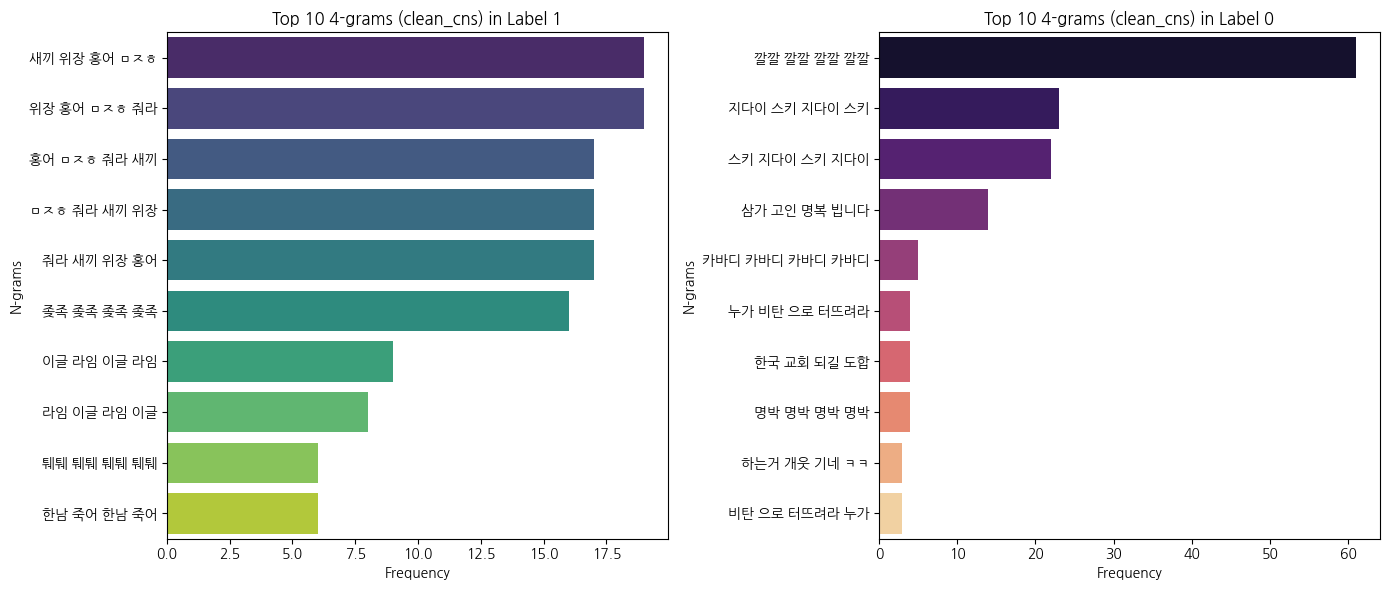

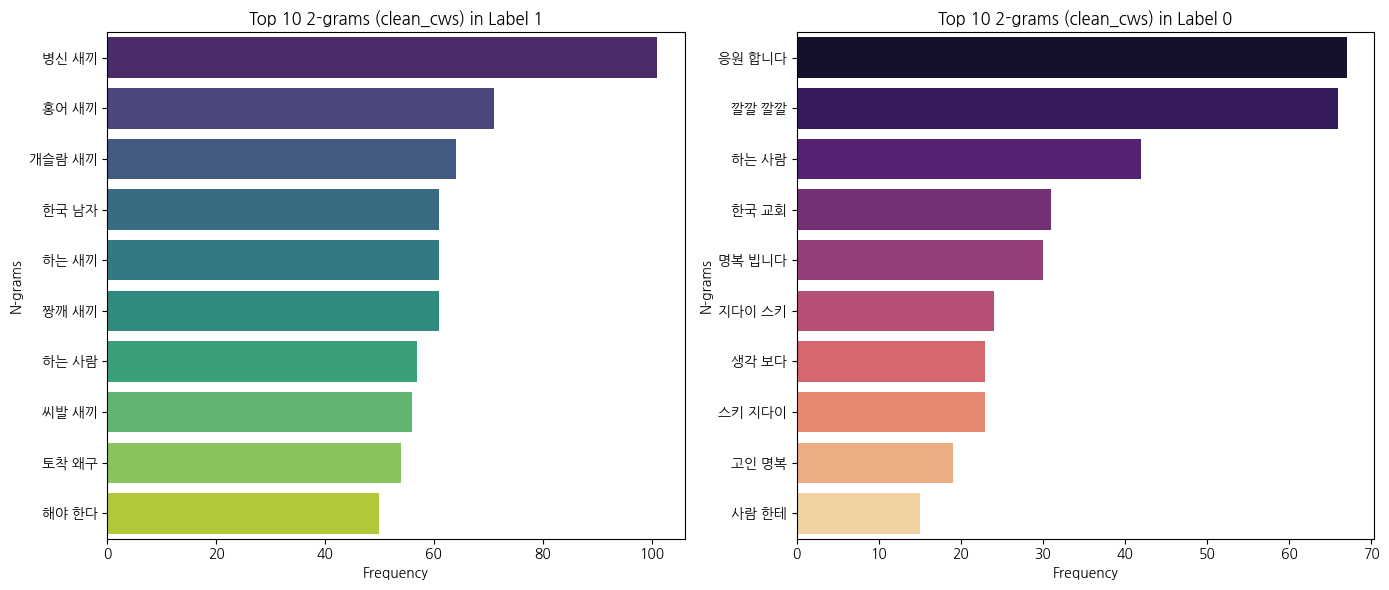

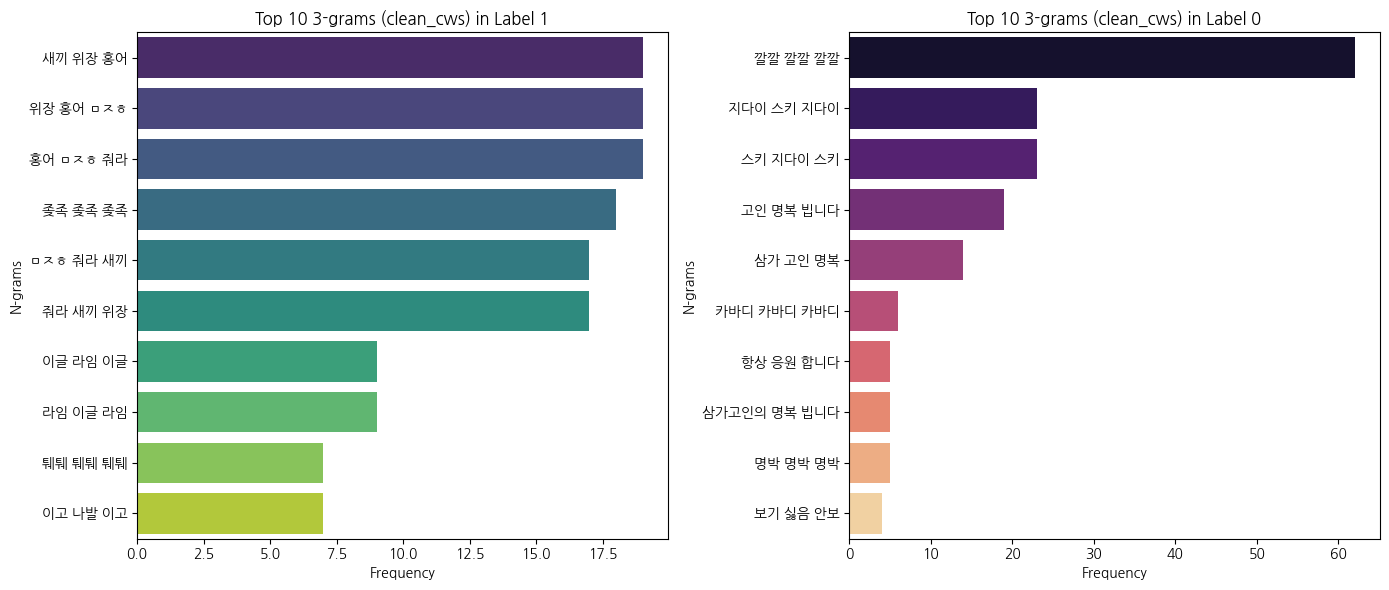

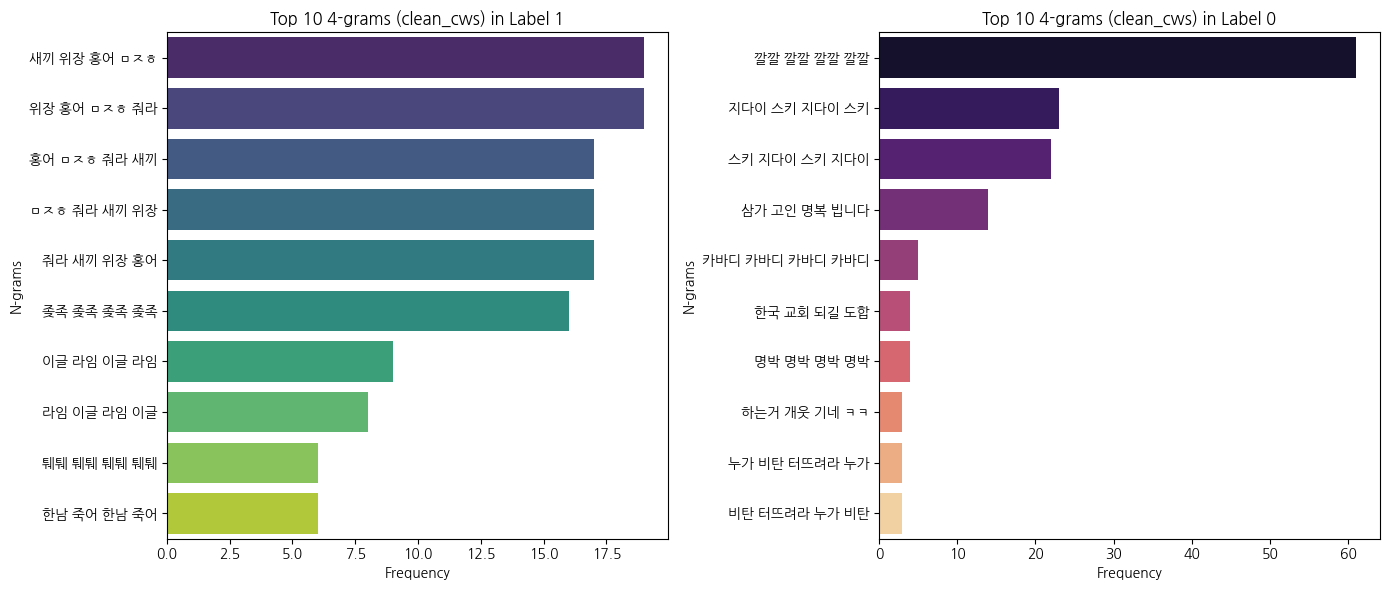

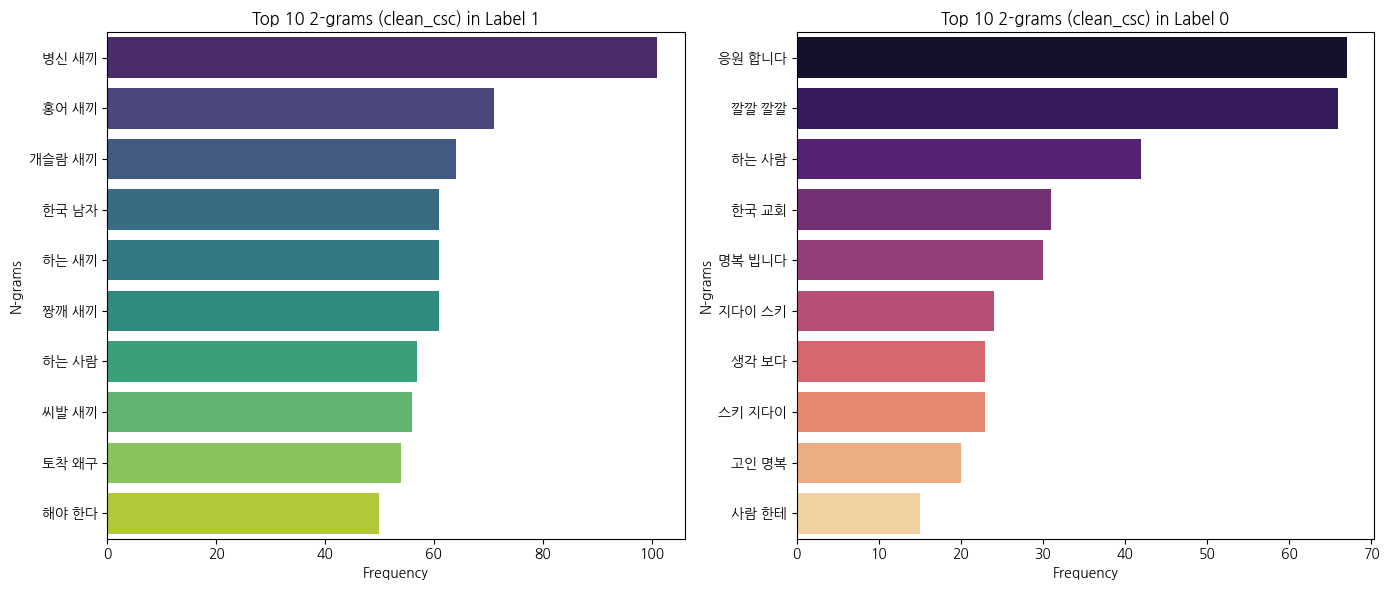

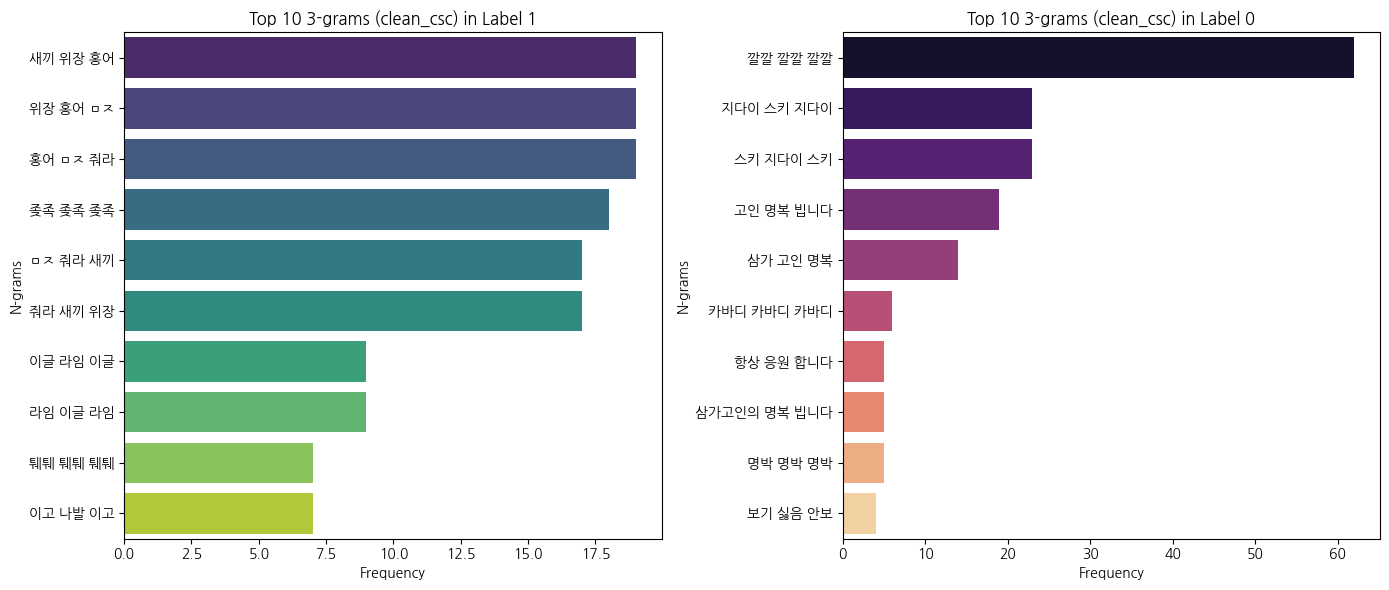

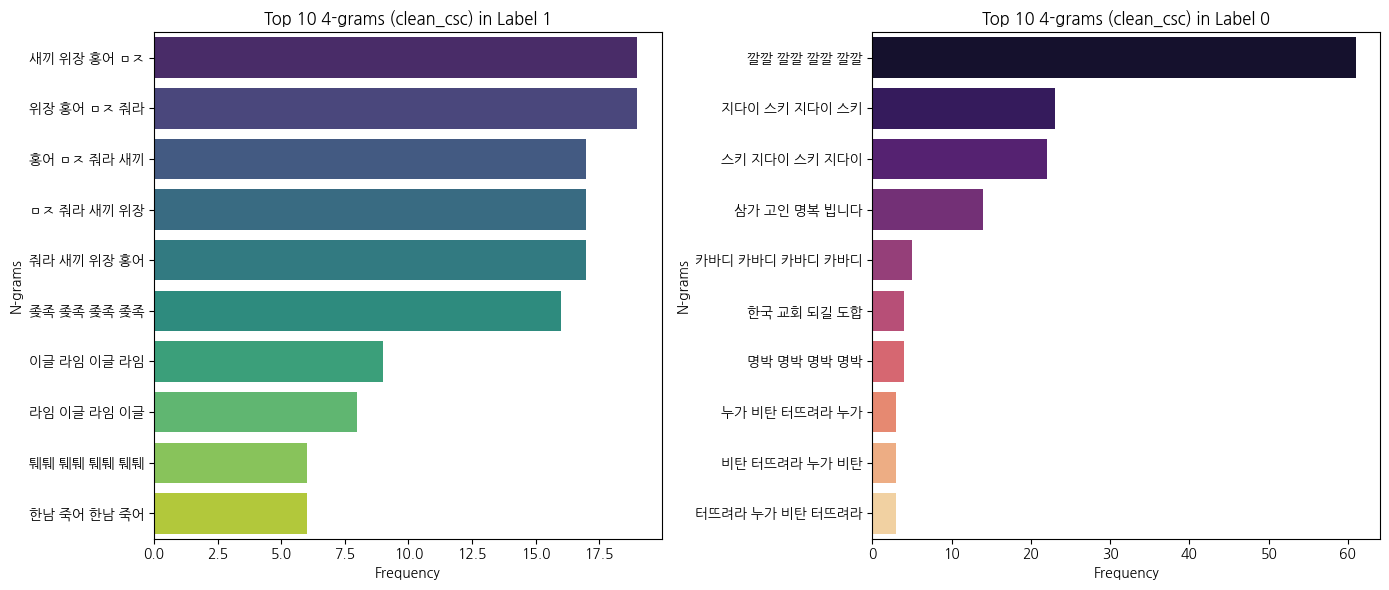

In [34]:
def get_top_n_grams(corpus, n=None, ngram_range=(2, 2), top=10):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top]

def calculate_ngrams(label_1_texts, label_0_texts, ngram_range):
    top_grams_label_1 = get_top_n_grams(label_1_texts, ngram_range=ngram_range)
    top_grams_label_0 = get_top_n_grams(label_0_texts, ngram_range=ngram_range)
    return top_grams_label_1, top_grams_label_0

def plot_ngrams(title, top_grams_label_1, top_grams_label_0):
    df_label_1 = pd.DataFrame(top_grams_label_1, columns=['ngram', 'frequency'])
    df_label_0 = pd.DataFrame(top_grams_label_0, columns=['ngram', 'frequency'])

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.barplot(data=df_label_1, x='frequency', y='ngram', palette='viridis')
    plt.title(f'Top 10 {title} in Label 1')
    plt.xlabel('Frequency')
    plt.ylabel('N-grams')

    plt.subplot(1, 2, 2)
    sns.barplot(data=df_label_0, x='frequency', y='ngram', palette='magma')
    plt.title(f'Top 10 {title} in Label 0')
    plt.xlabel('Frequency')
    plt.ylabel('N-grams')

    plt.tight_layout()
    plt.show()

for text_column in ['clean_cns', 'clean_cws', 'clean_csc']:
    text_label_1 = dataset[dataset['label'] == 1][text_column]
    text_label_0 = dataset[dataset['label'] == 0][text_column]

    for n in [2, 3, 4]:
        top_grams_label_1, top_grams_label_0 = calculate_ngrams(text_label_1, text_label_0, ngram_range=(n, n))
        plot_ngrams(f'{n}-grams ({text_column})', top_grams_label_1, top_grams_label_0)

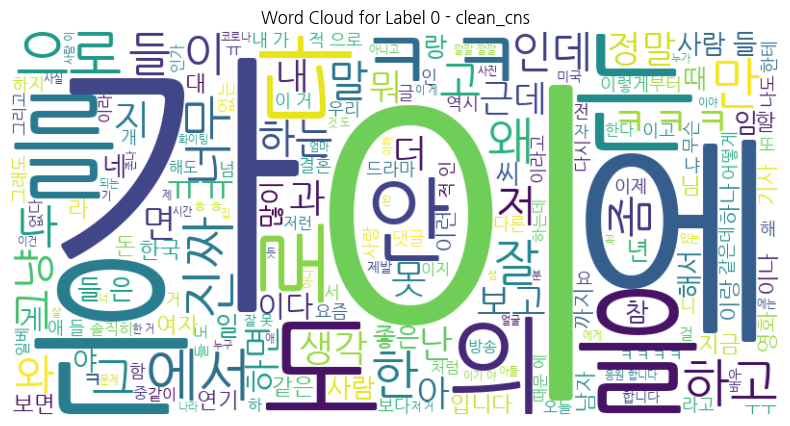

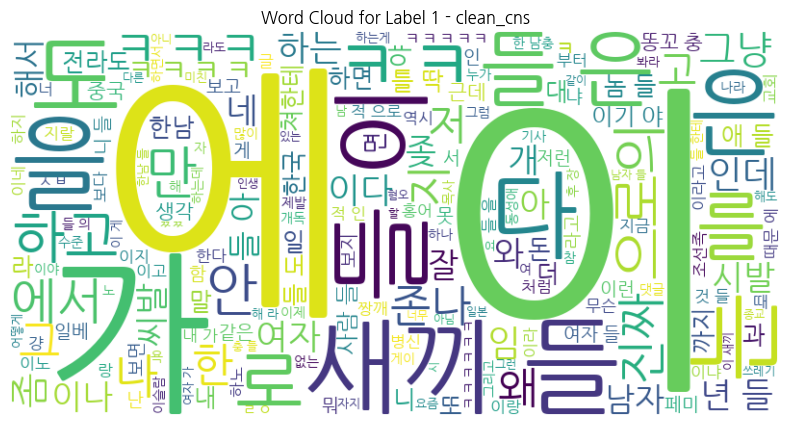

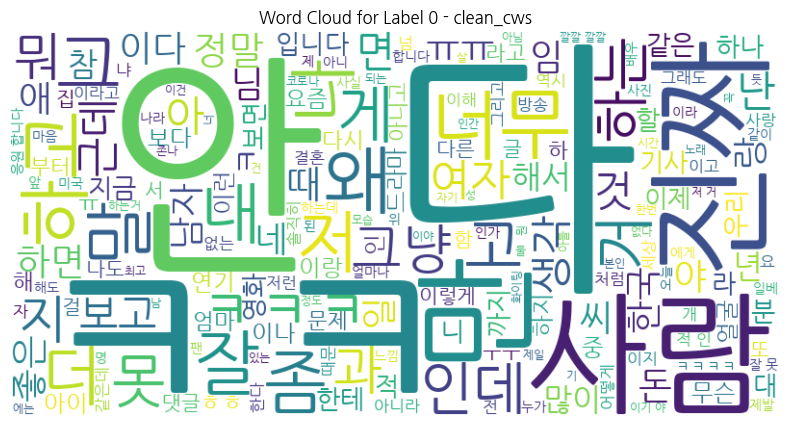

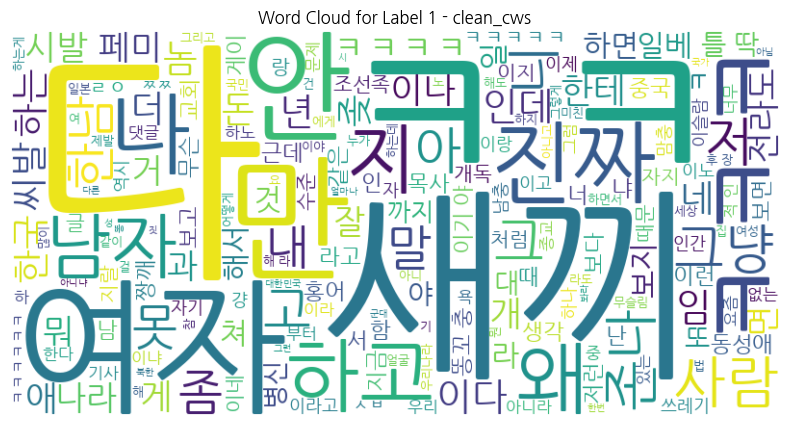

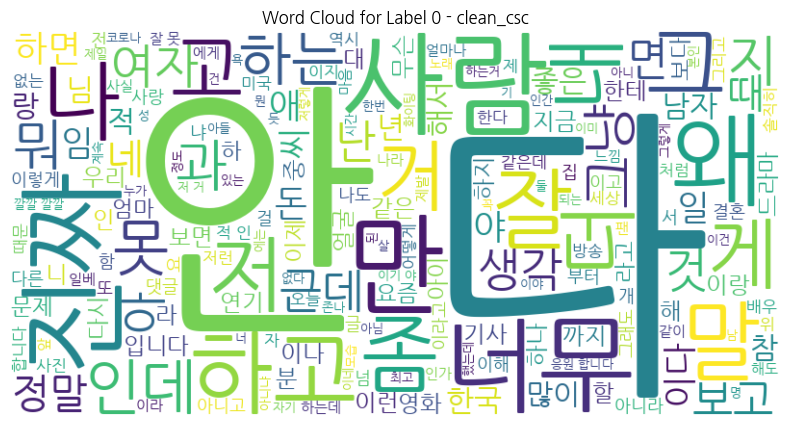

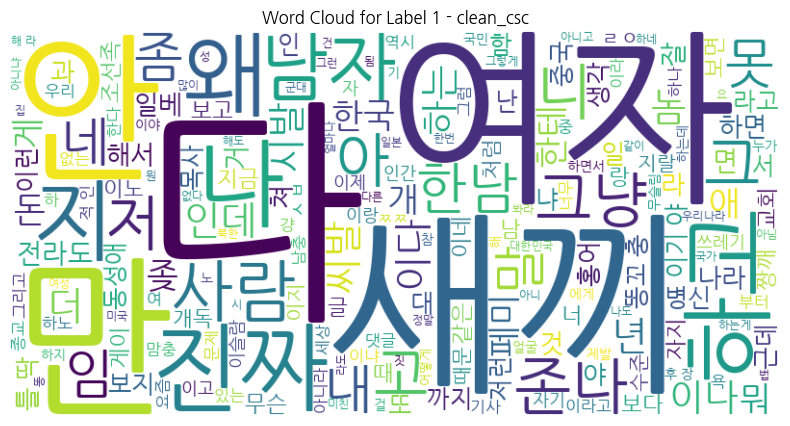

In [35]:
dataset['clean_cns'] = dataset['content'].apply(clean_ns)
dataset['clean_cws'] = dataset['content'].apply(clean_ws)
dataset['clean_csc'] = dataset['content'].apply(clean_sc)

def generate_wordcloud(text_column, label):
    text = ' '.join(dataset[dataset['label'] == label][text_column])
    wordcloud = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf', background_color='white', width=800, height=400).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Label {label} - {text_column}')
    plt.show()

for text_column in ['clean_cns', 'clean_cws', 'clean_csc']:
    for label in [0, 1]:
        generate_wordcloud(text_column, label)

In [36]:
pip install scikit-learn

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

In [38]:
vectorizer = CountVectorizer()
X_original = vectorizer.fit_transform(dataset['content'])
y = dataset['label']
X_train_original, X_test_original, y_train, y_test = train_test_split(X_original, y, test_size=0.3, random_state=42)

# 원본 데이터
model_original = MultinomialNB()
model_original.fit(X_train_original, y_train)
y_pred_original = model_original.predict(X_test_original)

print("Original Data")
print(f"Accuracy: {accuracy_score(y_test, y_pred_original):.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_original))

# 불용어 제거
dataset['clean_content_with_stopwords'] = dataset['content'].apply(clean_ws)
X_clean_with_stopwords = vectorizer.fit_transform(dataset['clean_cws'])
X_train_clean_with_stopwords, X_test_clean_with_stopwords, y_train, y_test = train_test_split(X_clean_with_stopwords, y, test_size=0.3, random_state=42)


model_clean_with_stopwords = MultinomialNB()
model_clean_with_stopwords.fit(X_train_clean_with_stopwords, y_train)
y_pred_clean_with_stopwords = model_clean_with_stopwords.predict(X_test_clean_with_stopwords)

print("Cleaned Data (With Stopwords)")
print(f"Accuracy: {accuracy_score(y_test, y_pred_clean_with_stopwords):.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_clean_with_stopwords))

# 특수 문자 제거
dataset['clean_csc'] = dataset['content'].apply(clean_sc)
X_clean_special_chars_removed = vectorizer.fit_transform(dataset['clean_csc'])
X_train_clean_special_chars_removed, X_test_clean_special_chars_removed, y_train, y_test = train_test_split(X_clean_special_chars_removed, y, test_size=0.3, random_state=42)


model_clean_special_chars_removed = MultinomialNB()
model_clean_special_chars_removed.fit(X_train_clean_special_chars_removed, y_train)
y_pred_clean_special_chars_removed = model_clean_special_chars_removed.predict(X_test_clean_special_chars_removed)

print("Cleaned Data (Special Characters Removed)")
print(f"Accuracy: {accuracy_score(y_test, y_pred_clean_special_chars_removed):.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_clean_special_chars_removed))

Original Data
Accuracy: 0.71
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.55      0.55      2805
           1       0.78      0.79      0.79      5817

    accuracy                           0.71      8622
   macro avg       0.67      0.67      0.67      8622
weighted avg       0.71      0.71      0.71      8622

Cleaned Data (With Stopwords)
Accuracy: 0.80
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.54      0.63      2805
           1       0.80      0.92      0.86      5817

    accuracy                           0.80      8622
   macro avg       0.79      0.73      0.75      8622
weighted avg       0.79      0.80      0.79      8622

Cleaned Data (Special Characters Removed)
Accuracy: 0.80
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.54      0.64      2805
           1       0.81      0.92    

전처리 후 데이터가 모델의 정확도를 개선 시킴 확인


In [39]:
def split_data(X, y, test_size=0.2, val_size=0.1):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(test_size + val_size), random_state=42)
    relative_test_size = test_size / (test_size + val_size)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=relative_test_size, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

# 원본 데이터
vectorizer = CountVectorizer()
X_original = vectorizer.fit_transform(dataset['content'])
y = dataset['label']
X_train_original, X_val_original, X_test_original, y_train, y_val, y_test = split_data(X_original, y)

model_original = MultinomialNB()
model_original.fit(X_train_original, y_train)
y_pred_val_original = model_original.predict(X_val_original)
y_pred_test_original = model_original.predict(X_test_original)

print("Original Data - Validation")
print(f"Accuracy: {accuracy_score(y_val, y_pred_val_original):.2f}")
print("Classification Report:")
print(classification_report(y_val, y_pred_val_original))

print("Original Data - Test")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test_original):.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_test_original))

# 불용어 제거 데이터
X_clean_with_stopwords = vectorizer.fit_transform(dataset['clean_cws'])
X_train_clean_with_stopwords, X_val_clean_with_stopwords, X_test_clean_with_stopwords, y_train, y_val, y_test = split_data(X_clean_with_stopwords, y)

model_clean_with_stopwords = MultinomialNB()
model_clean_with_stopwords.fit(X_train_clean_with_stopwords, y_train)
y_pred_val_clean_with_stopwords = model_clean_with_stopwords.predict(X_val_clean_with_stopwords)
y_pred_test_clean_with_stopwords = model_clean_with_stopwords.predict(X_test_clean_with_stopwords)

print("Cleaned Data (With Stopwords) - Validation")
print(f"Accuracy: {accuracy_score(y_val, y_pred_val_clean_with_stopwords):.2f}")
print("Classification Report:")
print(classification_report(y_val, y_pred_val_clean_with_stopwords))

print("Cleaned Data (With Stopwords) - Test")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test_clean_with_stopwords):.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_test_clean_with_stopwords))

# 특수 문자 제거 데이터
X_clean_special_chars_removed = vectorizer.fit_transform(dataset['clean_csc'])
X_train_clean_special_chars_removed, X_val_clean_special_chars_removed, X_test_clean_special_chars_removed, y_train, y_val, y_test = split_data(X_clean_special_chars_removed, y)

model_clean_special_chars_removed = MultinomialNB()
model_clean_special_chars_removed.fit(X_train_clean_special_chars_removed, y_train)
y_pred_val_clean_special_chars_removed = model_clean_special_chars_removed.predict(X_val_clean_special_chars_removed)
y_pred_test_clean_special_chars_removed = model_clean_special_chars_removed.predict(X_test_clean_special_chars_removed)

print("Cleaned Data (Special Characters Removed) - Validation")
print(f"Accuracy: {accuracy_score(y_val, y_pred_val_clean_special_chars_removed):.2f}")
print("Classification Report:")
print(classification_report(y_val, y_pred_val_clean_special_chars_removed))

print("Cleaned Data (Special Characters Removed) - Test")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test_clean_special_chars_removed):.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_test_clean_special_chars_removed))

Original Data - Validation
Accuracy: 0.72
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.54      0.56       957
           1       0.78      0.81      0.79      1917

    accuracy                           0.72      2874
   macro avg       0.68      0.67      0.67      2874
weighted avg       0.71      0.72      0.71      2874

Original Data - Test
Accuracy: 0.71
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.55      0.55      1848
           1       0.79      0.79      0.79      3901

    accuracy                           0.71      5749
   macro avg       0.67      0.67      0.67      5749
weighted avg       0.71      0.71      0.71      5749

Cleaned Data (With Stopwords) - Validation
Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.53      0.62       957
           1       0.80      0.9

In [40]:
from sklearn.model_selection import GridSearchCV

vectorizer = CountVectorizer()
X_cws = vectorizer.fit_transform(dataset['clean_csc'])
y = dataset['label']
X_train, X_val, y_train, y_val = train_test_split(X_cws, y, test_size=0.2, random_state=42)

param_grid = {'alpha': [0.1, 0.5, 1.0, 5.0, 10.0]}
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.2f}")

best_model = grid_search.best_estimator_
y_pred_val = best_model.predict(X_val)

print("Validation Data")
print(f"Accuracy: {accuracy_score(y_val, y_pred_val):.2f}")
print("Classification Report:")
print(classification_report(y_val, y_pred_val))

Best Parameters: {'alpha': 0.5}
Best Cross-Validation Accuracy: 0.79
Validation Data
Accuracy: 0.80
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.63      0.67      1874
           1       0.83      0.88      0.85      3874

    accuracy                           0.80      5748
   macro avg       0.77      0.75      0.76      5748
weighted avg       0.79      0.80      0.79      5748



'label 0'의 성능이 향상된것으로 보임